# Getting started with Landmark Explanation

Note: you can run **[this notebook live in Google Colab](https://colab.research.google.com/github/softlab-unimore/Landmark/blob/master/quick_start_magellan.ipynb)** and use free GPUs provided by Google.

This tutorial describes how to effortlessly explaining entity matching. Specifically, we will see how to match pairs of tuples (also called data records or table rows) to determine if they refer to the same real world entity. To do so, we will need labeled examples as input, i.e., tuple pairs which have been annotated as matches or non-matches. This will be used to train a model to explain using supervised learning. After that you will apply Landmark to get an explanation of the model over a record from your data. 

In this notebook you will use the [Magellan](https://github.com/anhaidgroup/py_entitymatching) library to:

1.   Extract feature similarity between the entities of each pair.
2.   Apply a ML model over the extracted features to predict the label.



## Step 0. Setup

If you are running this notebook inside Colab, you will first need to install necessary packages by running the code below:

In [ ]:
!pip install py_entitymatching

You may need to restart the kernel to use Magellan. That's OK.


### clone landmark code

In [ ]:
!git clone https://github.com/softlab-unimore/landmark.git
!pip install -r landmark/requirements.txt

fatal: destination path 'landmark' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import py_entitymatching as em # magellan

### Load data for entity matching

Now let's get some sample data to play with in this tutorial.

1. **Training Data:** This is used for training the model.
2. **Test Data:** We explain the behavior of the model over a record from the test.

In [ ]:

dataset_path = '/content/landmark/data/Abt-Buy/'
DA = em.read_csv_metadata(dataset_path + 'tableA.csv', key='id')[['id','name']]
DB = em.read_csv_metadata(dataset_path + 'tableB.csv', key='id')[['id','name']]

simplified_columns = ['id','left_id','right_id','label','left_name','right_name']
train = pd.read_csv(dataset_path + 'train_merged.csv')[simplified_columns]
test = pd.read_csv(dataset_path + 'test_merged.csv')[simplified_columns]

exclude_attrs=['id','left_id','right_id', 'label']

Metadata file is not present in the given path; proceeding to read the csv file.
Metadata file is not present in the given path; proceeding to read the csv file.


## Step 1. Magellan for Entity Matching

In [ ]:
# Magellan catalog declaration
em.set_key(train, 'id')
em.set_key(DA, 'id')
em.set_key(DB, 'id')
em.set_ltable(train, DA)
em.set_rtable(train, DB)
em.set_fk_ltable(train, 'left_id')
em.set_fk_rtable(train, 'right_id')

True

### Magellan Feature extraction

In [ ]:
feature_table = em.get_features_for_matching(DA[['name']],DB[['name']], validate_inferred_attr_types=False)
feature_table.head()

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source,is_auto_generated
0,name_name_jac_qgm_3_qgm_3,name,name,qgm_3,qgm_3,jaccard,<function name_name_jac_qgm_3_qgm_3 at 0x7fdfd00f0b90>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
1,name_name_cos_dlm_dc0_dlm_dc0,name,name,dlm_dc0,dlm_dc0,cosine,<function name_name_cos_dlm_dc0_dlm_dc0 at 0x7fdfaa88ff80>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
2,name_name_mel,name,name,None,None,monge_elkan,<function name_name_mel at 0x7fdfaa856f80>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
3,name_name_lev_dist,name,name,None,None,lev_dist,<function name_name_lev_dist at 0x7fdfaa887050>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True
4,name_name_lev_sim,name,name,None,None,lev_sim,<function name_name_lev_sim at 0x7fdfaa887170>,from py_entitymatching.feature.simfunctions import *\nfrom py_entitymatching.feature.tokenizers ...,True


In [ ]:
similarity_features = em.extract_feature_vecs(train, feature_table=feature_table, )
similarity_features = similarity_features.fillna(similarity_features.mean())

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [ ]:
similarity_features.head()

,id,left_id,right_id,name_name_jac_qgm_3_qgm_3,name_name_cos_dlm_dc0_dlm_dc0,name_name_mel,name_name_lev_dist,name_name_lev_sim
0,0,730,775,0.280488,0.404520,0.733421,41.0,0.405797
1,1,731,775,0.296296,0.404520,0.750564,39.0,0.434783
2,2,735,775,0.558824,0.674200,0.806667,30.0,0.571429
3,3,732,775,0.472222,0.539360,0.789124,32.0,0.542857
4,4,734,775,0.419753,0.516398,0.778857,42.0,0.475000


### Model Training over extracted featurs

In [ ]:
X = similarity_features.iloc[:, 3:]
y = train['label']
model = em.LogRegMatcher(name='LR', random_state=0, n_jobs=-1,
                         C=0.5, max_iter=100, class_weight={0: 1, 1:3})


test_precision    0.457200
test_recall       0.459360
test_f1           0.457231
dtype: float64

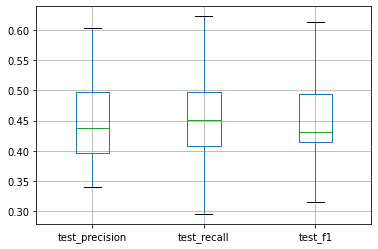

In [ ]:
from sklearn.model_selection import cross_validate

scores = pd.DataFrame(cross_validate(model.clf, X, y, cv=10, scoring=('precision', 'recall', 'f1')))
scores = scores.iloc[:,-3:] # remove time measures
scores.boxplot()
scores.mean()

In [ ]:
model.fit(X,y)

## Step2. Explanation using Landmark

In [ ]:
from landmark import Landmark

In [ ]:
# The explainer takes a predict method to analyse its behavior. 
# To this end I prepared for you a wrapper for the magellan feature extraction and model prediction.
from landmark.wrapper.MagellanWrapper import MagellanWrapper
mg_wrapped = MagellanWrapper(model, feature_table, exclude_attrs)

In [ ]:
explainer = Landmark(mg_wrapped.predict, test, exclude_attrs=exclude_attrs, lprefix='left_', rprefix='right_', split_expression=r' ')

In [ ]:
preds = mg_wrapped.predict(test)
test['pred'] = preds

Select an item to explain.

In [ ]:
el = test[test.id==270]
display(el)

,id,left_id,right_id,label,left_name,right_name,pred
270,270,574,399,0,sony digital slr camera with lens kit dslra200w,nikon digital camera leather case 5811,0.036606


### Explain a NO-MATCH item with token injection mechanism
Call explain to generate the explanation.

---


By default the **conf** parameter is set to 'auto' it means that the perturbation strategy depends on the label (that must exist in the DataFrame columns). 

*   If label == 1 --> *single* perturbation with landmark.
*   If label == 0 --> *double* perturbation with landmark. (*double* means that we inject tokens from the landmark description into the perturbed description) see the paper for more.

In [ ]:
%%time
exp = explainer.explain(el)

CPU times: user 1.5 s, sys: 107 ms, total: 1.61 s
Wall time: 1.48 s


In [ ]:
exp

,index,id,column,position,word,word_prefix,impact,conf
0,0,270,left_name,3,camera,A03_camera,0.169598,right_landmark_injection
1,1,270,left_name,11,5811,A11_5811,0.169033,right_landmark_injection
2,2,270,left_name,9,leather,A09_leather,0.156795,right_landmark_injection
3,3,270,left_name,1,digital,A01_digital,0.147384,right_landmark_injection
4,4,270,left_name,8,nikon,A08_nikon,0.114652,right_landmark_injection
5,5,270,left_name,10,case,A10_case,0.103808,right_landmark_injection
6,6,270,left_name,7,dslra200w,A07_dslra200w,-0.056287,right_landmark_injection
7,7,270,left_name,4,with,A04_with,-0.053079,right_landmark_injection
8,8,270,left_name,0,sony,A00_sony,-0.041644,right_landmark_injection
9,9,270,left_name,5,lens,A05_lens,-0.039848,right_landmark_injection


,id,left_id,right_id,label,left_name,right_name,pred
270,270,574,399,0,sony digital slr camera with lens kit dslra200w,nikon digital camera leather case 5811,0.036606


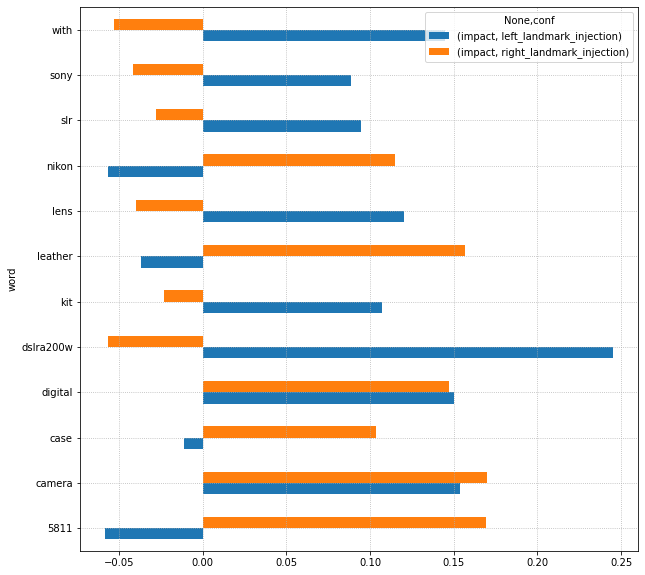

In [ ]:
to_plot = exp
figsize = (10,10)
aggregated = to_plot.pivot_table(index='word',values=['impact'],columns=['conf'], aggfunc='max' )
plot = aggregated.plot(kind='barh', figsize=figsize,)
plt.gca().grid(True, linestyle=':', axis='both')
el

,left_name,right_name
270,sony digital slr camera with lens kit dslra200w,nikon digital camera leather case 5811


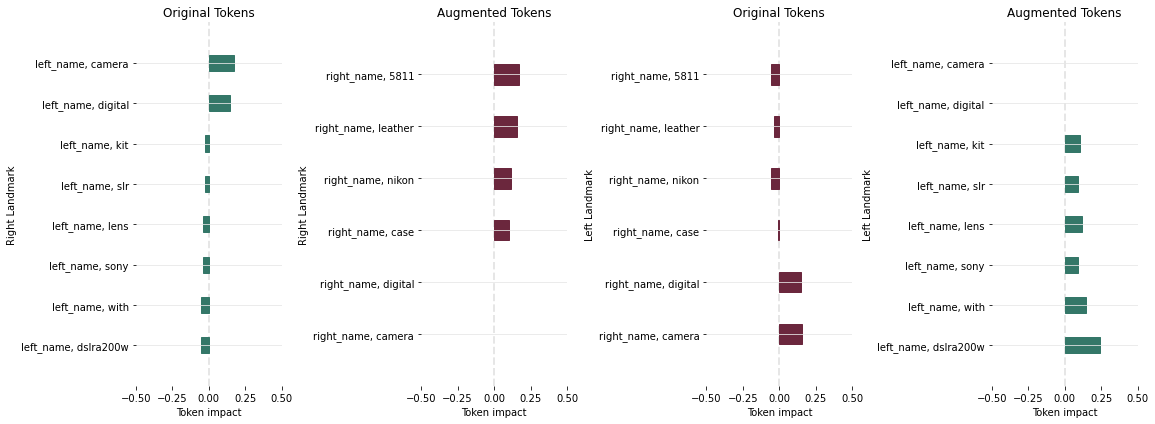

In [ ]:
explainer.plot(exp, el)
el[['left_name','right_name']]

In [ ]:
explainer.double_explanation_conversion(exp, el)

,column,position,word,score_right_landmark,score_left_landmark
0,left_name,3,camera,0.169598,0.000000
3,left_name,1,digital,0.147384,0.000000
6,left_name,7,dslra200w,-0.056287,0.244861
7,left_name,4,with,-0.053079,0.144611
8,left_name,0,sony,-0.041644,0.088754
9,left_name,5,lens,-0.039848,0.120528
10,left_name,2,slr,-0.027736,0.094380
11,left_name,6,kit,-0.022751,0.107172
13,right_name,2,camera,0.000000,0.153708
14,right_name,1,digital,0.000000,0.149920


### NO-MATCH with 'single' mechanism

In [ ]:
exp = explainer.explain(el, conf='single')

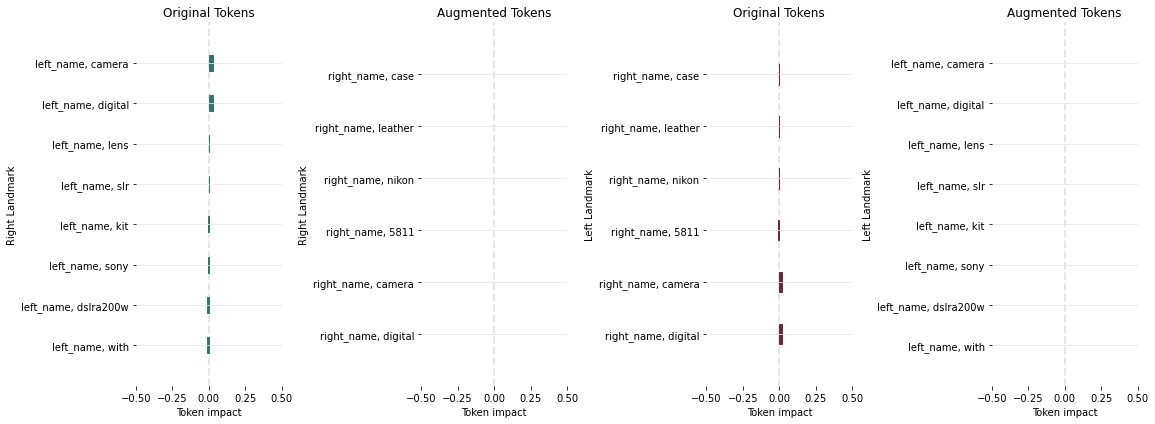

In [ ]:
explainer.plot(exp, el) # No augmented (injected) tokens

,id,left_id,right_id,label,left_name,right_name,pred
270,270,574,399,0,sony digital slr camera with lens kit dslra200w,nikon digital camera leather case 5811,0.036606


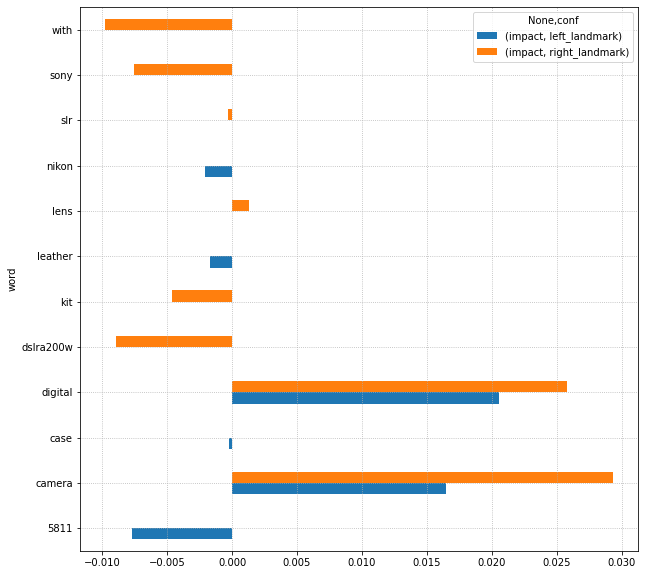

In [ ]:
to_plot = exp
figsize = (10,10)
aggregated = to_plot.pivot_table(index='word',values=['impact'],columns=['conf'], aggfunc='max' )
plot = aggregated.plot(kind='barh', figsize=figsize,)
plt.gca().grid(True, linestyle=':', axis='both')
el